In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms,datasets
from torch.utils.data import Dataset,DataLoader,random_split,Subset
import matplotlib.pyplot as plt 
import pandas as pd
import os
from PIL import Image
from DataPreparation.CustomDataSet import CustomDataSet
from AutoEncoders.SimpleAutoencoder import AutoEncoder
import numpy as np

In [4]:
from Pruning.laprune import LAP 

In [5]:
def transform(input):
    input = torch.FloatTensor(np.array(input))
    input = input.flatten()
    input = input.type(torch.FloatTensor)
    input -= torch.min(input)
    input /= torch.max(input)
    return input

In [6]:
dataset = CustomDataSet("DataPreparation/CorruptedFashionMNIST/Names.csv",
                      "DataPreparation/CorruptedFashionMNIST", transform=transform)

In [7]:
# finding the best parameters for autoencoder 
train_size = int(0.8 * len(dataset))  # 80% for training
validation_size = int(0.1*len(dataset))
test_size = len(dataset)-(train_size+validation_size)
train_dataset,validation_dataset,test_dataset = random_split(dataset,[train_size,validation_size,test_size])
print(train_size)
print(validation_size)

# Create DataLoader instances
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
validation_dataloader = DataLoader(validation_dataset,batch_size=64,shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64,shuffle=True)

48000
6000


In [9]:
def train_autoencoder(model, train_loader, val_loader, epochs, lr=0.01):
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = nn.MSELoss()
        train_losses = []
        val_losses = []

        for epoch in range(epochs):
            model.train()  # Set model to training mode
            total_train_loss = 0
            for X_batch, _ in train_loader:
                X_batch = X_batch.view(X_batch.size(0), -1)  # Reshape if necessary
                optimizer.zero_grad()
                outputs = model(X_batch)
                train_loss = criterion(outputs, X_batch)
                train_loss.backward()
                optimizer.step()
                total_train_loss += train_loss.item()
            avg_train_loss = total_train_loss / len(train_loader)
            train_losses.append(avg_train_loss)

                # Validation
            model.eval()  # Set model to evaluation mode
            total_val_loss = 0
            with torch.no_grad():
                for X_batch, _ in val_loader:
                    X_batch = X_batch.view(X_batch.size(0), -1)  # Reshape if necessary
                    outputs = model(X_batch)
                    val_loss = criterion(outputs, X_batch)
                    total_val_loss += val_loss.item()
            avg_val_loss = total_val_loss / len(val_loader)
            val_losses.append(avg_val_loss)

            print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

        return train_losses, val_losses

In [10]:
# Hyperparameters
hidden_sizes_options = [[128], [256, 128], [512, 256, 128]]
learning_rate_options = [0.01, 0.001]
epochs_options = [5, 10]
bottleneck_sizes = [64, 32]

best_val_loss = float('inf')
best_params = {}

for hidden_sizes in hidden_sizes_options:
    for lr in learning_rate_options:
        for epochs in epochs_options:
            for bottleneck_size in bottleneck_sizes:
                # Calculate 'layers' based on the length of hidden_sizes
                layers = len(hidden_sizes)
                
                # Adjusted model instantiation to include 'layers'
                model = AutoEncoder(input_size=784, bottleneck_size=bottleneck_size, hidden_sizes=hidden_sizes, layers=layers)
                print(f'Training with hidden_sizes={hidden_sizes}, lr={lr}, epochs={epochs}, bottleneck_size={bottleneck_size}, layers={layers}')
                
                # Updated to capture the return value correctly
                train_losses, val_losses = train_autoencoder(model, train_dataloader, validation_dataloader, epochs, lr)
                
                # Assuming you want to consider the last validation loss for comparison
                last_val_loss = val_losses[-1]
                if last_val_loss < best_val_loss:
                    best_val_loss = last_val_loss
                    best_params = {
                        'hidden_sizes': hidden_sizes,
                        'learning_rate': lr,
                        'epochs': epochs,
                        'bottleneck_size': bottleneck_size,
                        'layers': layers  # Keep track of the 'layers' in best parameters
                    }

print(f'Best Parameters: {best_params}')

Training with hidden_sizes=[128], lr=0.01, epochs=5, bottleneck_size=64, layers=1
Epoch 1, Train Loss: 0.0392, Val Loss: 0.0500
Epoch 2, Train Loss: 0.0500, Val Loss: 0.0498
Epoch 3, Train Loss: 0.0499, Val Loss: 0.0499
Epoch 4, Train Loss: 0.0498, Val Loss: 0.0498
Epoch 5, Train Loss: 0.0498, Val Loss: 0.0497
Training with hidden_sizes=[128], lr=0.01, epochs=5, bottleneck_size=32, layers=1
Epoch 1, Train Loss: 0.0414, Val Loss: 0.0391
Epoch 2, Train Loss: 0.0389, Val Loss: 0.0391
Epoch 3, Train Loss: 0.0386, Val Loss: 0.0399
Epoch 4, Train Loss: 0.0384, Val Loss: 0.0380
Epoch 5, Train Loss: 0.0383, Val Loss: 0.0379
Training with hidden_sizes=[128], lr=0.01, epochs=10, bottleneck_size=64, layers=1
Epoch 1, Train Loss: 0.0461, Val Loss: 0.0499
Epoch 2, Train Loss: 0.0499, Val Loss: 0.0500
Epoch 3, Train Loss: 0.0498, Val Loss: 0.0498
Epoch 4, Train Loss: 0.0498, Val Loss: 0.0497
Epoch 5, Train Loss: 0.0497, Val Loss: 0.0497
Epoch 6, Train Loss: 0.0497, Val Loss: 0.0497
Epoch 7, Train Lo

In [70]:
model = AutoEncoder(input_size=784,bottleneck_size=50,hidden_sizes=[128, 64] ,layers=2)
train_losses,val_losses = train_autoencoder(model, train_loader=train_dataloader,val_loader=validation_dataloader,epochs=100,lr=0.0003)

Epoch 1, Train Loss: 0.0347, Val Loss: 0.0226
Epoch 2, Train Loss: 0.0186, Val Loss: 0.0163
Epoch 3, Train Loss: 0.0153, Val Loss: 0.0145
Epoch 4, Train Loss: 0.0139, Val Loss: 0.0132
Epoch 5, Train Loss: 0.0128, Val Loss: 0.0124
Epoch 6, Train Loss: 0.0121, Val Loss: 0.0118
Epoch 7, Train Loss: 0.0116, Val Loss: 0.0115
Epoch 8, Train Loss: 0.0113, Val Loss: 0.0112
Epoch 9, Train Loss: 0.0110, Val Loss: 0.0109
Epoch 10, Train Loss: 0.0107, Val Loss: 0.0105
Epoch 11, Train Loss: 0.0103, Val Loss: 0.0102
Epoch 12, Train Loss: 0.0101, Val Loss: 0.0101
Epoch 13, Train Loss: 0.0099, Val Loss: 0.0098
Epoch 14, Train Loss: 0.0097, Val Loss: 0.0096
Epoch 15, Train Loss: 0.0095, Val Loss: 0.0094
Epoch 16, Train Loss: 0.0093, Val Loss: 0.0092
Epoch 17, Train Loss: 0.0092, Val Loss: 0.0092
Epoch 18, Train Loss: 0.0091, Val Loss: 0.0091
Epoch 19, Train Loss: 0.0090, Val Loss: 0.0089
Epoch 20, Train Loss: 0.0089, Val Loss: 0.0088
Epoch 21, Train Loss: 0.0088, Val Loss: 0.0087
Epoch 22, Train Loss: 

In [71]:
def eval_model(model, data_loader):
    model.eval()
    criterion = nn.MSELoss()
    total_loss = 0
    with torch.no_grad():
        for X_batch, _ in data_loader:
            X_batch = X_batch.view(X_batch.size(0), -1)
            outputs = model(X_batch)
            loss = criterion(outputs, X_batch)
            total_loss += loss.item()
    avg_loss = total_loss / len(data_loader)
    return avg_loss


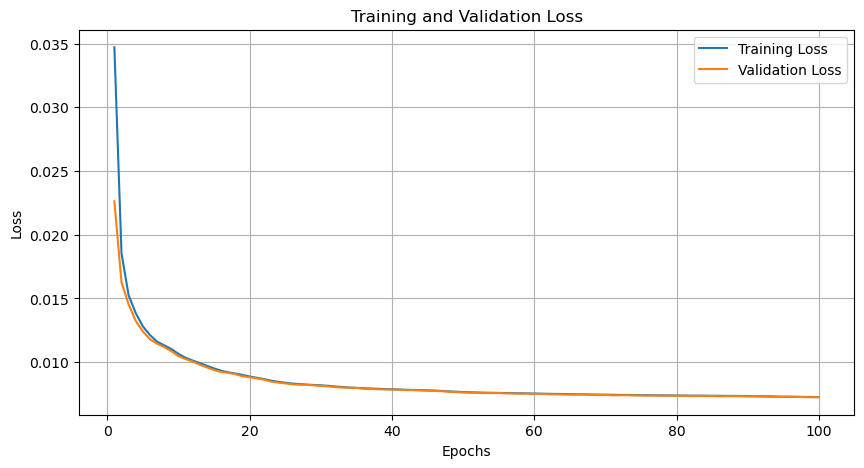

In [72]:
import matplotlib.pyplot as plt

# Assuming train_losses and val_losses are the lists returned from the train_autoencoder method
epochs = range(1, 100 + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import copy
import matplotlib.pyplot as plt
from Pruning.LookaheadPruning import apply_lap, calculate_sparsity

# Assuming 'model' is your pre-trained AutoEncoder and 'test_dataloader' is defined
prune_ratios = [0.2, 0.3, 0.4, 0.5,0.6,0.7,0.8,0.9]  # Define desired prune ratios to apply
sparsity_levels = []  # This will store the actual sparsity levels calculated from the model
test_losses = []

for ratio in prune_ratios:
    # Create a deep copy of the trained model to apply pruning
    pruned_model = copy.deepcopy(model)
    
    # Apply LAP pruning using the specified prune ratio
    apply_lap(pruned_model, [ratio] * len(pruned_model.hidden_sizes), bn_factors=None)
    
    # Calculate the actual sparsity level of the pruned model
    sparsity = calculate_sparsity(pruned_model)
    sparsity_levels.append(sparsity)
    
    # Evaluate the pruned model on the test dataset
    test_loss = eval_model(pruned_model, test_dataloader)
    test_losses.append(test_loss)
    print(f"Prune Ratio: {ratio}, Actual Sparsity Level: {sparsity:.4f}, Test Loss: {test_loss:.4f}")


In [74]:
def plot_sparsity(sparsity_levels, test_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(sparsity_levels, test_losses, '-o', label='Test Loss After Pruning')
    plt.xlabel('Sparsity Level')
    plt.ylabel('Test Loss')
    plt.title('Performance vs. Sparsity Level')
    plt.legend()
    plt.grid(True)
    plt.show()

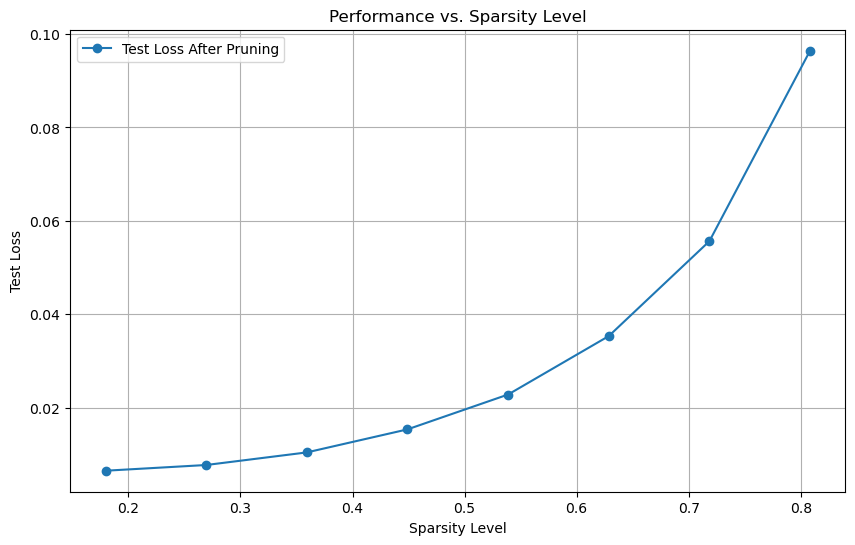

In [77]:
plot_sparsity(sparsity_levels, test_losses)

In [ ]:
import matplotlib.pyplot as plt
import torch
import copy

def display_reconstructed_images(model, test_dataloader, prune_ratios):
    # Select a batch of images from the test DataLoader.
    test_images, _ = next(iter(test_dataloader))
    original_images = test_images.view(test_images.size(0), -1)

    # Set the number of images to display
    num_images_to_show = 5
    fig, axes = plt.subplots(len(prune_ratios) + 1, num_images_to_show, figsize=(num_images_to_show * 2, 2 * (len(prune_ratios) + 1)))

    # Display original images
    for i in range(num_images_to_show):
        ax = axes[0][i]
        ax.imshow(original_images[i].view(28, 28).cpu().numpy(), cmap='gray')  # Adjust dimensions for your dataset
        ax.axis('off')
        if i == 0:
            ax.set_title('Original')

    # Display reconstructed images at each sparsity level
    for j, sparsity in enumerate(prune_ratios, start=1):
        # Prune the model copy at the current sparsity level
        pruned_model = copy.deepcopy(model)
        apply_lap(pruned_model, [sparsity] * len(pruned_model.hidden_sizes), bn_factors=None)

        # Generate reconstructed images from the pruned model
        pruned_model.eval()
        with torch.no_grad():
            reconstructed_images = pruned_model(original_images).cpu()

        # Plot the reconstructed images
        for i in range(num_images_to_show):
            ax = axes[j][i]
            ax.imshow(reconstructed_images[i].view(28, 28).cpu().numpy(), cmap='gray')  # Adjust dimensions for your dataset
            ax.axis('off')
            if i == 0:
                ax.set_title(f'Reconstructed\nSparsity {sparsity}')

    plt.tight_layout()
    plt.show()

# Assuming 'model' is the trained AutoEncoder, 'test_dataloader' is defined,
# and 'prune_ratios' is a list of desired sparsity levels
display_reconstructed_images(model, test_dataloader, [0.1, 0.2, 0.3, 0.4, 0.5])


In [ ]:
import Pruning.ShapSAE as SSAE

# Assuming 'model' is your pre-trained AutoEncoder and 'test_dataloader' is defined
prune_ratios = [0.2, 0.3, 0.4, 0.5,0.6,0.7,0.8,0.9]  # Define desired prune ratios to apply
sparsity_levels = []  # This will store the actual sparsity levels calculated from the model
test_losses = []
pruned_model = copy.deepcopy(model)
test_data = [data for data in test_dataloader]
importances = SSAE.calc_importance(pruned_model,test_data[0][0])


for ratio in prune_ratios:
    # Create a deep copy of the trained model to apply pruning
    pruned_model = copy.deepcopy(model)
    
    # Apply LAP pruning using the specified prune ratio
    pruned_model, _ = SSAE.prune(pruned_model, importances, ratio)
    
    
    # Evaluate the pruned model on the test dataset
    test_loss = eval_model(pruned_model, test_dataloader)
    test_losses.append(test_loss)
    print(f"Prune Ratio: {ratio}, Actual Sparsity Level: {sparsity:.4f}, Test Loss: {test_loss:.4f}")

In [ ]:
data = 'DataPreparation/CorruptedMNIST/Names.csv'

In [ ]:
root_dir = 'DataPreparation/CorruptedMNIST'
dataset = CustomDataSet(data, root_dir,transform=transform)

In [ ]:
# finding the best parameters for autoencoder 
train_size = int(0.8 * len(dataset))  # 80% for training
validation_size = int(0.1*len(dataset))
test_size = len(dataset)-(train_size+validation_size)
train_dataset,validation_dataset,test_dataset = random_split(dataset,[train_size,validation_size,test_size])
print(train_size)
print(validation_size)

# Create DataLoader instances
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
validation_dataloader = DataLoader(validation_dataset,batch_size=64,shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64,shuffle=True)

In [ ]:
model = AutoEncoder(input_size=784,bottleneck_size=50,hidden_sizes=[128, 64] ,layers=2)
train_losses,val_losses = train_autoencoder(model, train_loader=train_dataloader,val_loader=validation_dataloader,epochs=100,lr=0.0003)

In [ ]:
def eval_model(model, data_loader):
    model.eval()
    criterion = nn.MSELoss()
    total_loss = 0
    with torch.no_grad():
        for X_batch, _ in data_loader:
            X_batch = X_batch.view(X_batch.size(0), -1)
            outputs = model(X_batch)
            loss = criterion(outputs, X_batch)
            total_loss += loss.item()
    avg_loss = total_loss / len(data_loader)
    return avg_loss


In [ ]:
import copy
import matplotlib.pyplot as plt
from Pruning.LookaheadPruning import apply_lap, calculate_sparsity

# Assuming 'model' is your pre-trained AutoEncoder and 'test_dataloader' is defined
prune_ratios = [0.2, 0.3, 0.4, 0.5,0.6,0.7,0.8,0.9]  # Define desired prune ratios to apply
sparsity_levels = []  # This will store the actual sparsity levels calculated from the model
test_losses = []

for ratio in prune_ratios:
    # Create a deep copy of the trained model to apply pruning
    pruned_model = copy.deepcopy(model)
    
    # Apply LAP pruning using the specified prune ratio
    apply_lap(pruned_model, [ratio] * len(pruned_model.hidden_sizes), bn_factors=None)
    
    # Calculate the actual sparsity level of the pruned model
    sparsity = calculate_sparsity(pruned_model)
    sparsity_levels.append(sparsity)
    
    # Evaluate the pruned model on the test dataset
    test_loss = eval_model(pruned_model, test_dataloader)
    test_losses.append(test_loss)
    print(f"Prune Ratio: {ratio}, Actual Sparsity Level: {sparsity:.4f}, Test Loss: {test_loss:.4f}")


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(sparsity_levels, test_losses, '-o', label='Test Loss After Pruning')
plt.xlabel('Sparsity Level')
plt.ylabel('Test Loss')
plt.title('Performance vs. Sparsity Level')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
display_reconstructed_images(model, test_dataloader, [0.1, 0.2, 0.3, 0.4, 0.5])


{4: array([0.00221492, 0.        , 0.00049693, ..., 0.        , 0.        ,
        0.00038646]),
 2: array([0.00000000e+00, 3.50200608e-04, 8.21063330e-05, ...,
        0.00000000e+00, 4.53406860e-06, 0.00000000e+00]),
 0: array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        7.38563989e-06, 0.00000000e+00, 9.39430845e-06])}

In [117]:
import Pruning.ShapSAE as SSAE

# Assuming 'model' is your pre-trained AutoEncoder and 'test_dataloader' is defined
prune_ratios = [0.2, 0.3, 0.4, 0.5,0.6,0.7,0.8,0.9]  # Define desired prune ratios to apply
sparsity_levels = []  # This will store the actual sparsity levels calculated from the model
test_losses = []
pruned_model = copy.deepcopy(model)
test_data = [data for data in test_dataloader]
#importances = SSAE.calc_importance(pruned_model,test_data[0][0])


for ratio in prune_ratios:
    # Create a deep copy of the trained model to apply pruning
    pruned_model = copy.deepcopy(model)
    
    # Apply LAP pruning using the specified prune ratio
    pruned_model, _ = SSAE.prune(pruned_model, importances, ratio)
    
    
    # Evaluate the pruned model on the test dataset
    test_loss = eval_model(pruned_model, test_dataloader)
    test_losses.append(test_loss)
    print(f"Prune Ratio: {ratio}, Actual Sparsity Level: {sparsity:.4f}, Test Loss: {test_loss:.4f}")


5it [00:00, 416.58it/s]


Prune Ratio: 0.2, Actual Sparsity Level: 0.8082, Test Loss: 0.1791


5it [00:00, 416.61it/s]


Prune Ratio: 0.3, Actual Sparsity Level: 0.8082, Test Loss: 0.1713


5it [00:00, 333.29it/s]


Prune Ratio: 0.4, Actual Sparsity Level: 0.8082, Test Loss: 0.1616


5it [00:00, 384.64it/s]


Prune Ratio: 0.5, Actual Sparsity Level: 0.8082, Test Loss: 0.1565


5it [00:00, 416.71it/s]


Prune Ratio: 0.6, Actual Sparsity Level: 0.8082, Test Loss: 0.1425


5it [00:00, 454.54it/s]


Prune Ratio: 0.7, Actual Sparsity Level: 0.8082, Test Loss: 0.1369


5it [00:00, 384.61it/s]


Prune Ratio: 0.8, Actual Sparsity Level: 0.8082, Test Loss: 0.0933


5it [00:00, 384.62it/s]


Prune Ratio: 0.9, Actual Sparsity Level: 0.8082, Test Loss: 0.0567


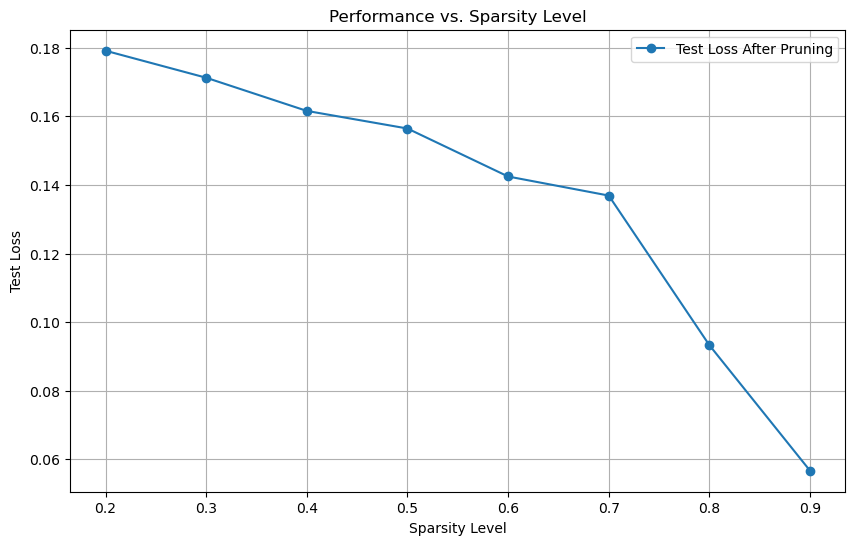

In [118]:
plt.figure(figsize=(10, 6))
plt.plot(prune_ratios, test_losses, '-o', label='Test Loss After Pruning')
plt.xlabel('Sparsity Level')
plt.ylabel('Test Loss')
plt.title('Performance vs. Sparsity Level')
plt.legend()
plt.grid(True)
plt.show()

5it [00:00, 294.13it/s]
5it [00:00, 333.29it/s]
5it [00:00, 333.35it/s]
5it [00:00, 384.62it/s]
5it [00:00, 312.51it/s]
5it [00:00, 416.71it/s]
5it [00:00, 416.70it/s]
5it [00:00, 416.64it/s]


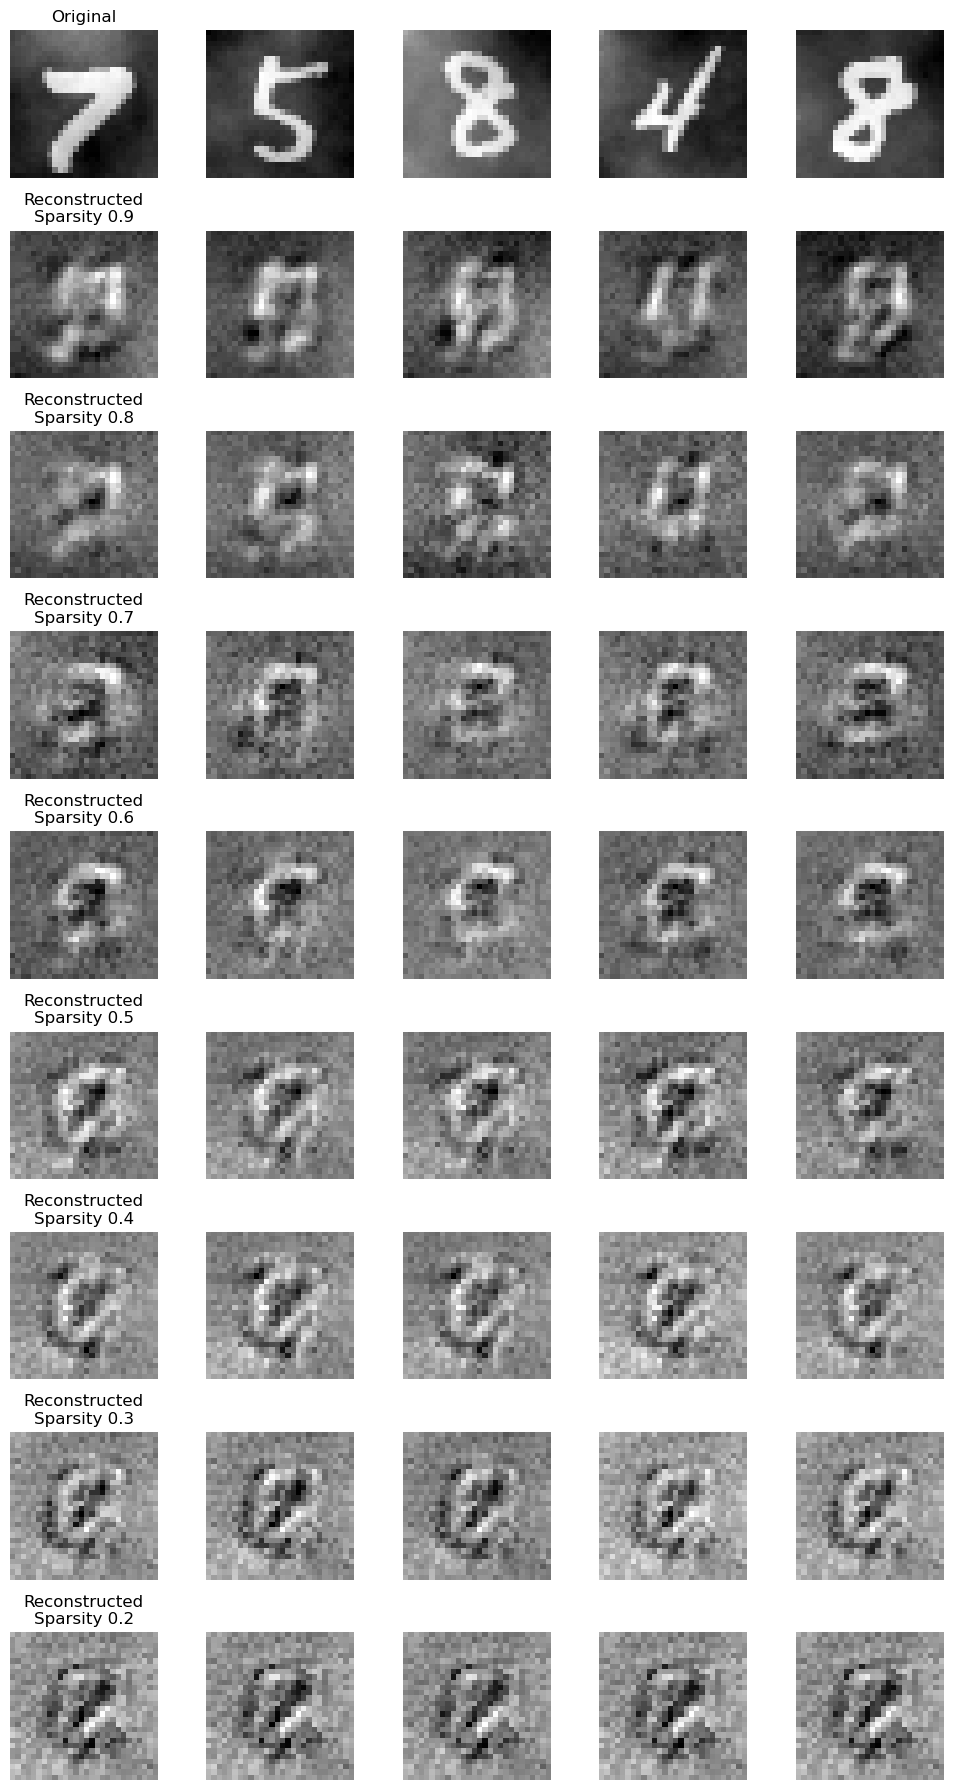

In [112]:
def display_reconstructed_images(model, test_dataloader, importances, importance_levels):
    # Select a batch of images from the test DataLoader.
    test_images, _ = next(iter(test_dataloader))
    original_images = test_images.view(test_images.size(0), -1)

    # Set the number of images to display
    num_images_to_show = 5
    fig, axes = plt.subplots(len(prune_ratios) + 1, num_images_to_show, figsize=(num_images_to_show * 2, 2 * (len(prune_ratios) + 1)))

    # Display original images
    for i in range(num_images_to_show):
        ax = axes[0][i]
        ax.imshow(original_images[i].view(28, 28).cpu().numpy(), cmap='gray')  # Adjust dimensions for your dataset
        ax.axis('off')
        if i == 0:
            ax.set_title('Original')

    # Display reconstructed images at each sparsity level
    for j, sparsity in enumerate(importance_levels, start=1):
        # Prune the model copy at the current sparsity level
        pruned_model = copy.deepcopy(model)
        pruned_model, _ = SSAE.prune(pruned_model, importances, sparsity)

        # Generate reconstructed images from the pruned model
        pruned_model.eval()
        with torch.no_grad():
            reconstructed_images = pruned_model(original_images).cpu()

        # Plot the reconstructed images
        for i in range(num_images_to_show):
            ax = axes[j][i]
            ax.imshow(reconstructed_images[i].view(28, 28).cpu().numpy(), cmap='gray')  # Adjust dimensions for your dataset
            ax.axis('off')
            if i == 0:
                ax.set_title(f'Reconstructed\nSparsity {sparsity}')

    plt.tight_layout()
    plt.show()

display_reconstructed_images(model, test_dataloader, importances, [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2])